# Taxi-V2

Mini project in [Udacity Deep Reinforcement Learning](http://bit.ly/drlndlinks) course, [module 8.1-8.3](https://classroom.udacity.com/nanodegrees/nd893/parts/8f607726-757e-4ef5-8b64-f2368755b89a/modules/a85374fa-6a60-425b-a480-85b211c5bd5d/lessons/508d0cf2-7545-48e8-95a0-7ac9467cfad7/concepts/ddb32ccb-2ae0-4c9d-82b0-f45e07271beb)

This notebook is an annotated version of the write up by [jo4x962k7JL](https://github.com/jo4x962k7JL/OpenAI-Gym-Taxi-v2).

First we examine the **Taxi-v2** environment, displaying and executing a few methods

In [2]:
from collections import deque, defaultdict
import sys, math, random
import numpy as np
import gym
import time
from IPython.display import display, clear_output

In [3]:
env = gym.make('Taxi-v2')
_ = [print(item) for item in dir(env) if not item.startswith('_')]

action_space
class_name
close
compute_reward
env
metadata
observation_space
render
reset
reward_range
seed
spec
step
unwrapped


In [4]:
env.action_space

Discrete(6)

In [5]:
env.observation_space

Discrete(500)

    rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters: locations

In [6]:
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



We define an **Agent** (a taxi) with a Q table that will ultimately hold arrays of 6 values (one for each possible action) for each of the 500 states.

In [7]:
class Agent:
    def __init__(self, nA=6, 
                 eps_range=[1e-3, 1e-6], 
                 alpha_range=[1e-2, 1e-3], 
                 gamma_range=[0.99, 0.8], 
                 decay_steps=30000):
        self.nA = nA
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        self.decay_steps = decay_steps
        self.epsilons = np.linspace(eps_range[0], eps_range[1], self.decay_steps)
        self.alphas = np.linspace(alpha_range[0], alpha_range[1], self.decay_steps)
        self.gammas = np.linspace(gamma_range[0], gamma_range[1], self.decay_steps)
        
    def select_action(self, state, i_episode):
        self.epsilon = self.epsilons[min(i_episode, self.decay_steps-1)]
        self.alpha = self.alphas[min(i_episode, self.decay_steps-1)]
        self.gamma = self.gammas[min(i_episode, self.decay_steps-1)]
        qmax_index = np.argmax(self.Q[state])
        if random.uniform(0, 1) > self.epsilon:
            return qmax_index
        else:
            return random.randrange(self.nA)
        
    def step(self, state, action, reward, next_state, done):
        new_value = (1 - self.alpha) * self.Q[state][action] + \
            self.alpha * (reward + self.gamma * np.max(self.Q[next_state]))
        self.Q[state][action] = new_value

In [10]:
def interact(env, agent, num_episodes=100000, window=100):
    avg_rewards = list()
    best_avg_reward = -math.inf
    samp_rewards = deque(maxlen=window)
    
    # initialize history deques
    alpha_history = deque(maxlen=num_episodes)
    gamma_history = deque(maxlen=num_episodes)
    epsilon_history = deque(maxlen=num_episodes)

    for i_episode in range(1, num_episodes+1):
        state = env.reset()
        samp_reward = 0
        while True:
            action = agent.select_action(state, i_episode)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            samp_reward += reward
            # every 10000 episodes
            if i_episode % 10000 == 0:
                # show the state
                clear_output(wait=True)
                print('i_episode:{}'.format(i_episode))
                print('state:{} reward:{} sampled reward:{}'.format(state, reward, samp_reward))
                env.render()
                time.sleep(0.2)
            state = next_state
            if done:
                samp_rewards.append(samp_reward)
                break
        if (i_episode >= 100):
            avg_reward = np.mean(samp_rewards)
            avg_rewards.append(avg_reward)
            
            # append to histories
            alpha_history.append(agent.alpha)
            gamma_history.append(agent.gamma)
            epsilon_history.append(agent.epsilon)
            
            if avg_reward > best_avg_reward:
                best_avg_reward = avg_reward
        print("\rEpisode {} , epsilon = {:.8f}, alpha = {:.5f}, gamma = {:.3f}|| Best average reward {:.3f}".format(
            i_episode, agent.epsilon, agent.alpha, agent.gamma, best_avg_reward), end="")
        sys.stdout.flush()
        
        # check if task is solved (according to OpenAI Gym)
        if best_avg_reward >= 9.7:
            print('\nEnvironment solved in {} episodes.'.format(i_episode), end="")
            break
        if i_episode == num_episodes: print('\n')
    return avg_rewards, best_avg_reward, (alpha_history, gamma_history, epsilon_history)

In [11]:
env = gym.make('Taxi-v2')
agent = Agent()
avg_rewards, best_avg_reward, history_tuple = interact(env, agent)

i_episode:100000
state:418 reward:20 sampled reward:9
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
Episode 100000 , epsilon = 0.00000100, alpha = 0.00100, gamma = 0.800|| Best average reward 9.420



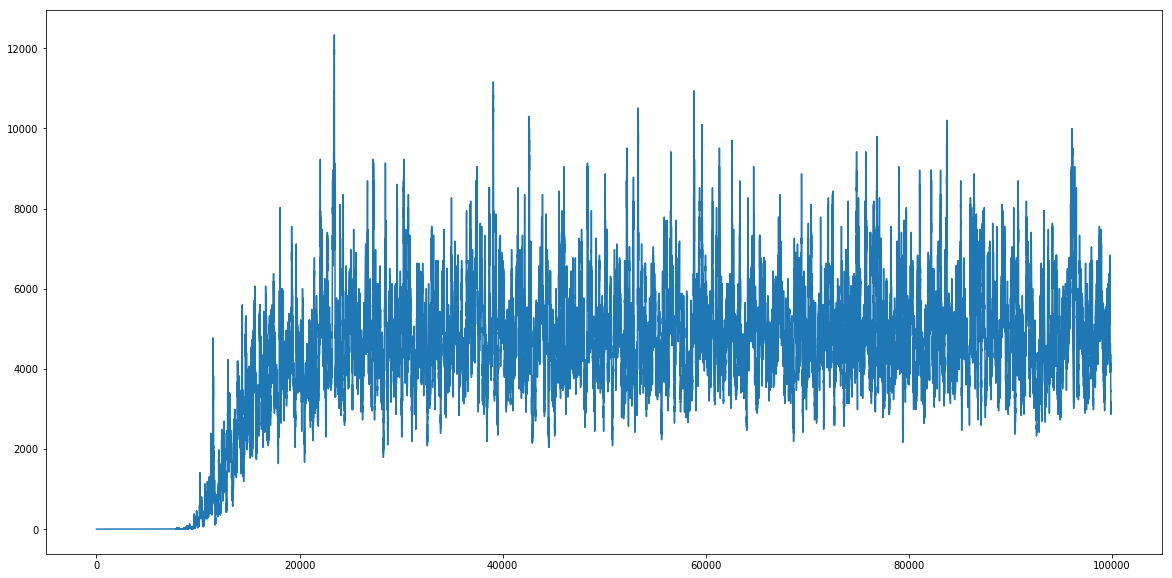

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20, 10))
plt.plot(np.exp(avg_rewards))
plt.show()

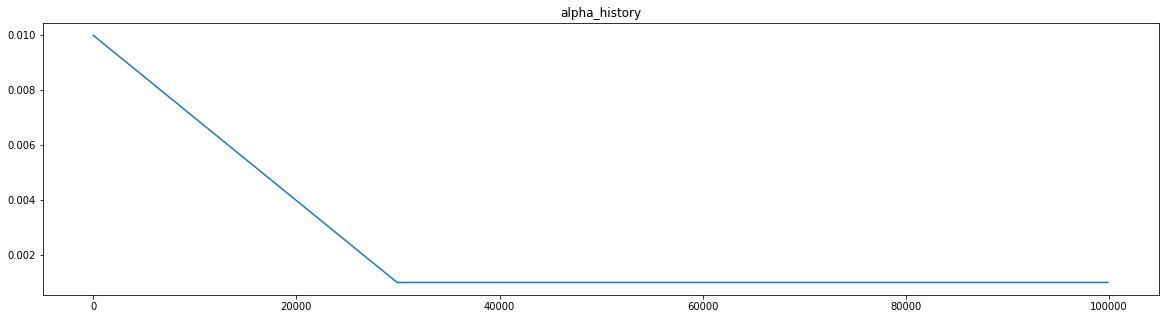

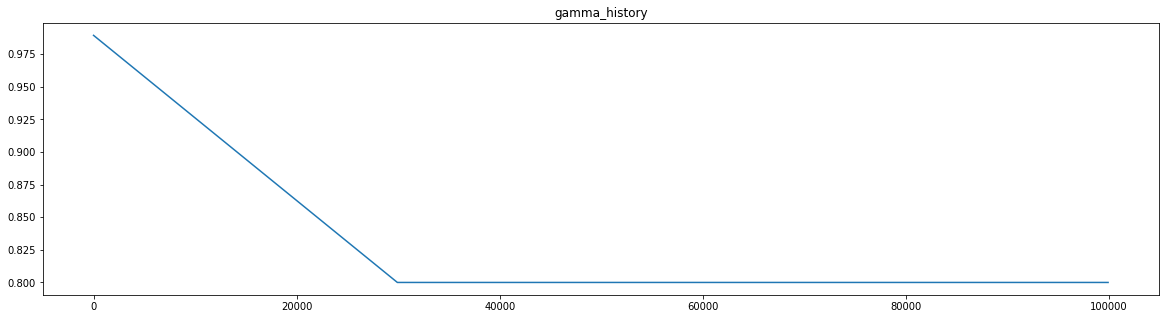

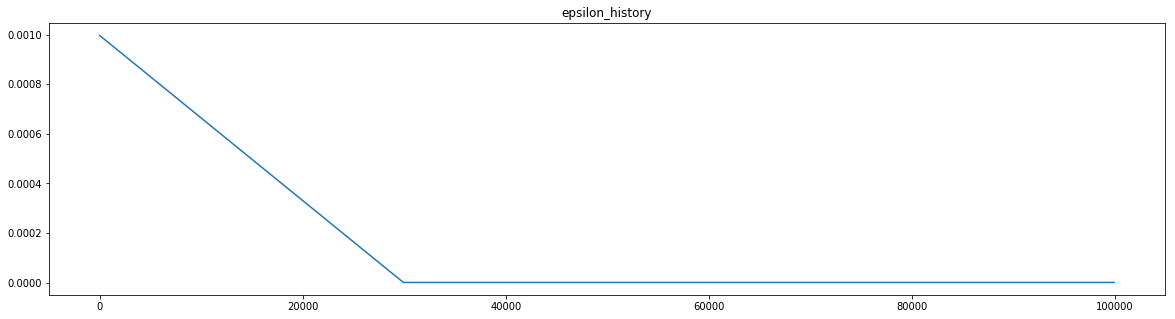

In [13]:
history_title = ['alpha_history', 'gamma_history', 'epsilon_history']
for index, title in enumerate(history_title):
    plt.figure(figsize=(20, 5))
    plt.title(title)
    plt.plot(history_tuple[index])
    plt.show()